In [1]:
import numpy as np
import pandas as pd
from sklearn import svm 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import MinMaxScaler # normalization
import matplotlib.pyplot as plt # plotting
import seaborn # plottin
from PIL import Image # image opening
import math
import os

In [2]:
# img1 = Image.open('./data/im1/00468.png')
# img2 = Image.open('./data/im2/00468.png')
img_1 = Image.open('./data/SECOND_train_set/im1/00003.png')
img_2 = Image.open('./data/SECOND_train_set/im2/00003.png')

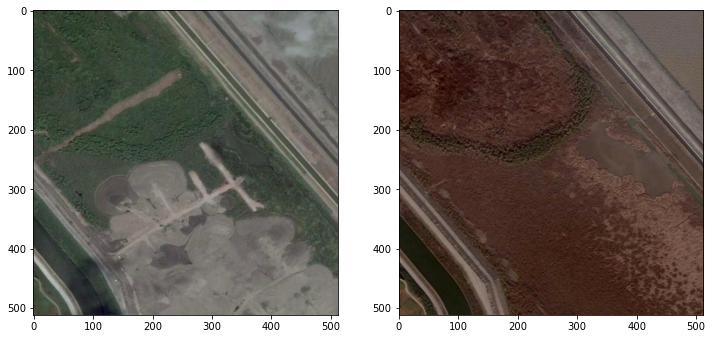

In [3]:
f, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(img_1)
ax[1].imshow(img_2)

In [4]:
# PLOTTING
def plot_array_as_image(X, m, n, is_1d=False):
    if is_1d:
        X = X.reshape((m, n))
    plt.figure(figsize=(8, 8))
    plt.imshow(X)
    
def plot_deltas(count_deltas, p_value_ind):
    plt.figure(figsize=(8, 8))

    plt.plot(count_deltas, label='deltas based on frobenius norm', color='b')
    plt.axvline(x=p_value_ind, label='p_value_ind', color='r')
    plt.legend()
    plt.tight_layout()

In [5]:
class Data:
    # IMAGE SCANNING
    def scan_img_color(self, path_img1, path_img2):
        img1 = Image.open(path_img1)
        img2 = Image.open(path_img2)

        # take the difference between two images
        difference = np.array(img1, dtype=np.int16) - np.array(img2, dtype=np.int16)
        self.m, self.n, self.dim = difference.shape
        self.samples = self.m * self.n
        # reshape it
        difference = difference.reshape((self.samples, self.dim), order='C')
        # normalize them and save in X
        self.X = MinMaxScaler().fit_transform(difference)
        # now count norms for each pixel's difference
        self.norms = np.array([np.linalg.norm(pixel_diff) for pixel_diff in self.X])
    
        self.y = np.full(self.samples, False, dtype=bool)
        self.classify_changes(p_value=0.6, show_deltas=False, is_bw=False)
        plot_array_as_image(self.y, self.m, self.n, is_1d=True)

    def scan_img_bw(self, path_img1, path_img2):
        img1 = Image.open(path_img1).convert('L')
        img2 = Image.open(path_img2).convert('L')

        # take the difference between two images
        difference = np.array(img1, dtype=np.int16) - np.array(img2, dtype=np.int16)
        self.m, self.n = difference.shape
        self.samples = self.m * self.n
        # reshape it
        difference = difference.reshape((self.samples, 1), order='C')
        # normalize them and save in X
        self.X = MinMaxScaler().fit_transform(difference)
        self.norms = self.X
    
        # LABELS PART
        self.y = np.full(self.samples, False, dtype=bool)
        self.classify_changes(p_value=0.6, show_deltas=False, is_bw=True)
        plot_array_as_image(self.y, self.m, self.n, is_1d=True)
        plot_array_as_image(self.X, self.m, self.n, is_1d=True)

    def scan_dir_imgs_color(self, path_images1, path_images2, path_labels, m=512, n=512, dim=3, cnt_images=1, start_from=0):
        # suppose images are named the same in all 3 directories
        # We will use each pixel as a sample with dim features
        # Storing samples in X and labels in y

        img_filenames = os.listdir(path_images1)

        self.m, self.n, self.features = m, n, dim
        self.img_size = self.m * self.n
        self.samples = cnt_images * self.img_size
        self.X = np.array([np.full(self.features, 0.0, dtype=np.float64) for i in range(self.samples)])
        self.y = np.full(self.samples, False, dtype=bool)

        for im_ind in range(start_from, len(img_filenames)):
            if im_ind % 10 == 0 or im_ind == cnt_images - 1:
                print("image no.", im_ind)

            # IMAGES PART
            img1 = Image.open(path_images1 + "/" + img_filenames[im_ind])
            img2 = Image.open(path_images2 + "/" + img_filenames[im_ind])

            # take the difference between two images
            difference = np.array(img1, dtype=np.int16) - np.array(img2, dtype=np.int16)
            # reshape it
            difference = difference.reshape((self.img_size, self.features), order='C')
            # normalize them
            difference = MinMaxScaler().fit_transform(difference)

            # save pixel norms as features in X[im_ind]
            for pixel_ind in range(self.img_size):
                self.X[im_ind * self.img_size + pixel_ind] = difference[pixel_ind]
        
            # LABELS PART
            img_labels = Image.open(path_labels + "/" + img_filenames[im_ind]).convert('L')    
            pixel_labels = np.array(img_labels, dtype=np.int16).reshape((self.img_size, 1))

            # store bool(pixel_label)
            for pixel_ind in range(self.img_size):
                self.y[im_ind * self.img_size + pixel_ind] = bool(pixel_labels[pixel_ind] - 255)
            
            # for testing
            if cnt_images == 1:
                plot_array_as_image(self.y, self.m, self.n, is_1d=True)
        
            # stop criteria
            if im_ind == cnt_images - 1:
                break

    def scan_dir_imgs_bw(self, path_images1, path_images2, path_labels, m=512, n=512, cnt_images=1, start_from=0):
        # suppose images are named the same in all 3 directories
        # We will use each pixel as a sample with dim features
        # Storing samples in X and labels in y

        img_filenames = os.listdir(path_images1)

        self.m, self.n, self.features = m, n, 1
        self.img_size = self.m * self.n
        self.samples = cnt_images * self.img_size
        self.X = np.array([np.full(self.features, 0.0, dtype=np.float64) for i in range(self.samples)])
        self.y = np.full(self.samples, False, dtype=bool)

        for im_ind in range(start_from, len(img_filenames)):
            if im_ind % 10 == 0 or im_ind == cnt_images - 1:
                print("image no.", im_ind)

            # IMAGES PART
            img1 = Image.open(path_images1 + "/" + img_filenames[im_ind]).convert('L')
            img2 = Image.open(path_images2 + "/" + img_filenames[im_ind]).convert('L')

            # take the difference between two images
            difference = np.array(img1, dtype=np.int16) - np.array(img2, dtype=np.int16)
            # reshape it
            difference = difference.reshape((self.img_size, self.features), order='C')
            # normalize them
            difference = MinMaxScaler().fit_transform(difference)

            # save pixel norms as features in X[im_ind]
            for pixel_ind in range(self.img_size):
                self.X[im_ind * self.img_size + pixel_ind] = difference[pixel_ind]
        
            # LABELS PART
            img_labels = Image.open(path_labels + "/" + img_filenames[im_ind]).convert('L')    
            pixel_labels = np.array(img_labels, dtype=np.int16).reshape((self.img_size, 1))

            # store bool(pixel_label)
            for pixel_ind in range(self.img_size):
                self.y[im_ind * self.img_size + pixel_ind] = bool(pixel_labels[pixel_ind] - 255)
            
            # for testing
            if cnt_images == 1:
                plot_array_as_image(self.y, self.m, self.n, is_1d=True)
        
            # stop criteria
            if im_ind == cnt_images - 1:
                break

In [31]:
class Clusterizer:
    # assuming the image is n * n pixels and has 1 feature
    # if clustering color image, you have to pass pixel norms matrix
    # and cluster_size divides n
    def __init__(self, X, y, samples, n, cluster_size):
        self.n = n
        self.samples = samples
        self.cluster_size = cluster_size
        self.n_clusters = int(n / cluster_size)
        
        self.X = X
        self.y = y

        self.X_clusters = np.full((self.n_clusters * self.n_clusters, 1), 0.0, dtype=np.float64)
        self.y_clusters = np.full((self.n_clusters * self.n_clusters, 1), 0, dtype=np.int32)

    # def train_test_split(self, test_size=0.2):
    #     self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size, random_state=42)

    # CLUSTERING
    def count_cluster(self, data, clusters, ind1, ind2):
        for i in range(self.cluster_size * ind1, self.cluster_size * ind1 + self.cluster_size):
            for j in range(self.cluster_size * ind2, self.cluster_size * ind2 + self.cluster_size):
                clusters[ind1 * self.n_clusters + ind2] += data[i * self.n + j]
        clusters[ind1 * self.n_clusters + ind2] /= (self.n_clusters * self.n_clusters)

    def clusterize_data(self):
        # working with square images m * m
        # suppose cluster_size divides m

        for i in range(self.n_clusters):
            for j in range(self.n_clusters):
                self.count_cluster_X(self.X, self.X_clusters, i, j)
                self.count_cluster_y(self.y, self.y_clusters, i, j)
                self.y_clusters = np.sign(self.y_clusters)
        
    
    # CLASSIFYING Y
    def count_p_value_edge(self, X, p_value, show_deltas=False, is_bw=True):
        n_deltas = 100
        count_deltas = np.zeros(shape=n_deltas, dtype=np.int32)

        # for each dimension we will count deltas 
        # in ranges [0, 0.05), [0.05, 0.1), [0.1, 0.15), ...

        for i in range(self.samples):
            delta_ind = 0
            if is_bw:
                delta_ind = min(int(self.X[i] * n_deltas), n_deltas - 1)
            else:
                delta_ind = min(int(self.norms[i] * n_deltas / math.sqrt(self.dim)), n_deltas - 1)
            count_deltas[delta_ind] += 1

        part_sums_deltas = np.zeros(shape=n_deltas, dtype=np.int32)
        for i in range(n_deltas):
            part_sums_deltas[i] = part_sums_deltas[i - 1] + count_deltas[i]
        
        p_value_ind = np.searchsorted(part_sums_deltas, p_value * self.samples)
        if show_deltas:
            plot_deltas(count_deltas, p_value_ind)

        p_value_diff = 0.0
        if is_bw:
            p_value_diff = p_value_ind / n_deltas
        else:
            p_value_diff = p_value_ind * math.sqrt(self.dim) / n_deltas


    def classify_changes(self, p_value_X, enable_clustering=False, p_value_clusters=0.0, show_deltas=False, is_bw=True):
        if enable_clustering:
            self.clusterize_data()
            p_value_cluster_edge = self.count_p_value_edge(self.clusters, p_value_clusters, show_deltas, is_bw)
        
        p_value_edge = self.count_p_value_edge(self.X, p_value_X, show_deltas, is_bw)

        for i in range(self.m):
            for j in range(self.n):
                if enable_clustering:
                    ind1 = math.floor(i / self.cluster_size)
                    ind2 = math.floor(j / self.cluster_size)
                    #
                if is_bw and self.X[i * self.n + j] >= p_value_edge:
                        self.y[i * self.n + j] = True
                elif self.norms[i * self.n + j] >= p_value_edge:
                        self.y[i * self.n + j] = True


    # TRAIN / TEST WITH SVM
    def train_classifier(self, X_train, y_train):
        self.clf = svm.SVC(kernel='rbf')
        self.clf.fit(X_train, y_train)
        print(self.clf.score(self.X, self.y))

    def test_classifier(self, X_test, y_test):
        self.predicted_labels = self.clf.predict(self.X)
        plot_array_as_image(self.predicted_labels, self.m, self.n, is_1d=True)

In [15]:
path_im1 = './data/SECOND_train_set/im1/'
path_im2 = './data/SECOND_train_set/im2/'
path_labels = './data/SECOND_train_set/label1/'

# path_img1 = './data/SECOND_train_set/im1/00003.png'
# path_img2 = './data/SECOND_train_set/im2/00003.png'

cnt_train_images = 10
D_train = Data()
D_train.scan_dir_imgs_bw(path_im1, path_im2, path_labels, m=512, n=512, cnt_images=cnt_train_images)

image no. 0
image no. 9


In [32]:
CL = Clusterizer(D_train.X, D_train.y, D_train.samples, D_train.n, cluster_size=16)
CL.clusterize_data()
plot_array_as_image(CL.X_clusters, m=CL.clusters_per_axis, n=CL.clusters_per_axis, is_1d=True)

AttributeError: 'Clusterizer' object has no attribute 'n_clusters'

In [26]:
print(CL.clusters[-10:])

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [9]:
print(D_train.X.shape, D_train.y.shape)
clf = svm.SVC(kernel='rbf', gamma='scale', C=10)
clf.fit(D_train.X, D_train.y)

(2621440, 1) (2621440,)


In [ ]:
D_test = Data()
D_test.scan_dir_imgs_bw(path_im1, path_im2, path_labels, cnt_images=1, start_from=cnt_train_images)

0.52


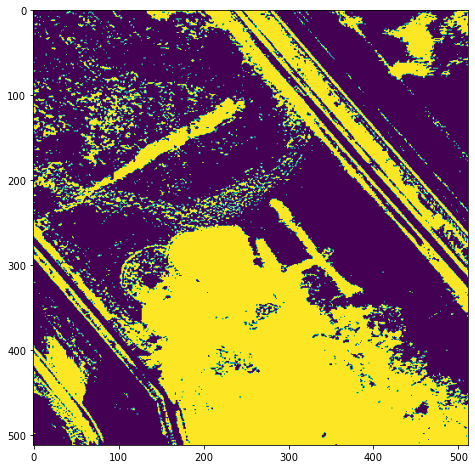

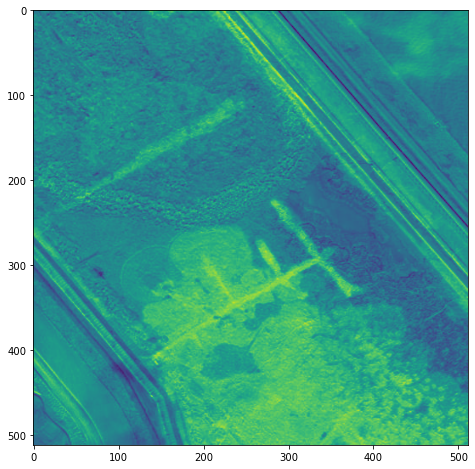

In [394]:
print(predicted_labels.shape)
plot_array_as_image(predicted_labels, D.m, D.n, id_1d=True)

На примере данной фотографии мы видим 2 экстремума по дельтам, однако в датасете чаще всего будет лишь один максимум. 

In [395]:
D.train_classifier()

1.0


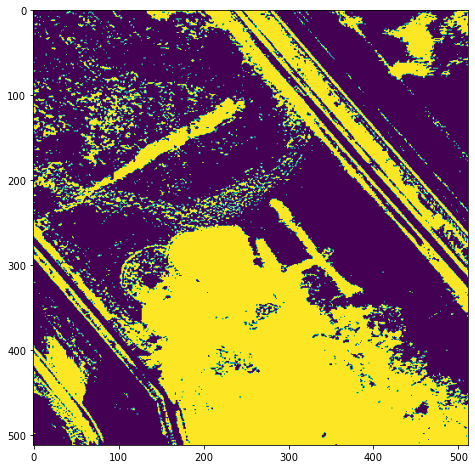

In [396]:
D.test_classifier()